This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


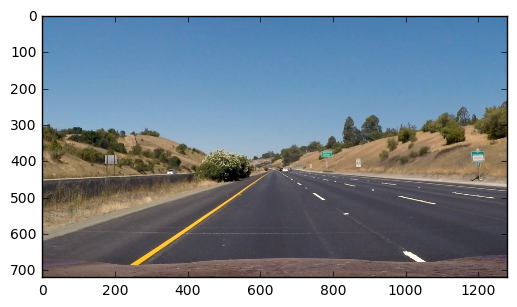

In [2]:
# Inverse perspective mapping
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import cv2
import glob
import time
import os
import logging
import argparse
import sys
import math
import imageio
from moviepy.editor import VideoFileClip
#imageio.plugins.ffmpeg.download()

#path = glob.glob('./'+'test_images'+'/'+'test6.jpg')
path = '/Users/enterprise/Dev/Git/Lane-Detection/test_images/straight_lines1.jpg'

orig_img = mpimg.imread(path)
plt.imshow(orig_img)
#printing out some stats and plotting
img_size = orig_img.shape
print('This image is:', type(orig_img), 'with dimesions:', img_size)

PREV_LEFT_SLOPE = 0
PREV_RIGHT_SLOPE = 0
PREV_LEFT_POINTS = [0,0,0]
PREV_RIGHT_POINTS = [0,0,0]


In [3]:
def camera_cal(folder,file,pattern_x,pattern_y,square_size):
    
    # pattern_x = 10 
    # pattern_y = 7
    # square_size = 1

    pattern_size = (pattern_x -1, pattern_y - 1) 
    pattern_points = np.zeros((np.prod(pattern_size), 3), np.float32)
    pattern_points[:, :2] = np.indices(pattern_size).T.reshape(-1, 2)
    pattern_points *= square_size

    obj_points = []
    img_points = []
    h, w = 0, 0
    img_names_undistort = []
    
    # create image list
    images = glob.glob('./'+folder+'/'+file+'*'+'.jpg')
    out_path = glob.glob('./'+folder+'/')
    out = False
    
    for fn in images:
        #print('processing %s... ' % fn, end='')
        img = cv2.imread(fn)
        if img is None:
            #print("Failed to load", fn)
            continue
        h, w = img.shape[:2]
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, pattern_size)
        if ret:
            term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 0.1)
            cv2.cornerSubPix(gray, corners, (5, 5), (-1, -1), term)
            img_points.append(corners)
            #.reshape(-1, 2)
            obj_points.append(pattern_points)

        if out:
            cv2.drawChessboardCorners(vis, pattern_size, corners, found)
            outfile = glog.glob(out_path+file+'_chess.png')
            cv2.imwrite(outfile, vis)
            if found:
                img_names_undistort.append(outfile)
        if not ret:
            #print('chessboard not found')
            continue

    #print('ok')

    # calculate camera distortion
    rms, camera_matrix, dist_coefs, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, (w, h), None, None)

    #print("\nRMS:", rms)
    #print("camera matrix:\n", camera_matrix)
    # print("matrix: \n", type(camera_matrix))
    #print("distortion coefficients: ", dist_coefs.ravel())
    
    return(camera_matrix,dist_coefs)
    
def undistort_1(image, camera_matrix, dist_coefs):
    image = cv2.undistort(image,camera_matrix,dist_coefs)
    return(image)

def undistort_2(image,camera_matrix, dist_coefs):
    h,w =image.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coefs, (w, h), 1, (w, h))
    undst = cv2.undistort(image, camera_matrix, dist_coefs, None, newcameramtx)
    x, y, w, h = roi
    undst = undst[y:y+h, x:x+w]
    return(undst)

In [4]:
# CALL CAMERA CALIBRATION FUNCTION
camera_matrix, dist_coefs = camera_cal('camera_cal','calibration',10,7,1)

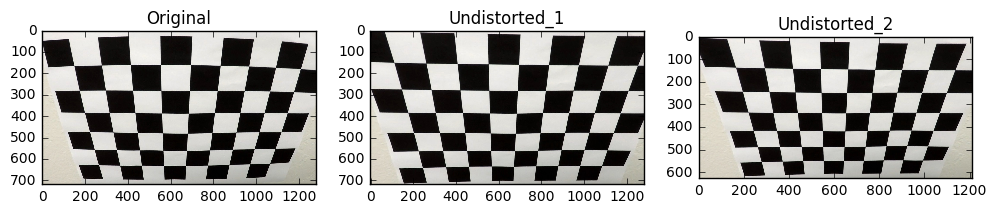

In [5]:
# TEST DISTORTION CORRECTION

distorted_image = mpimg.imread("./camera_cal/calibration2.jpg")
corrected1 = undistort_1(distorted_image, camera_matrix, dist_coefs)
corrected2 = undistort_2(distorted_image, camera_matrix, dist_coefs)


f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(12, 18))
ax1.imshow(distorted_image)
ax1.set_title('Original', fontsize=12)
ax2.imshow(corrected1)
ax2.set_title('Undistorted_1', fontsize=12)
ax3.imshow(corrected2)
ax3.set_title('Undistorted_2', fontsize=12)

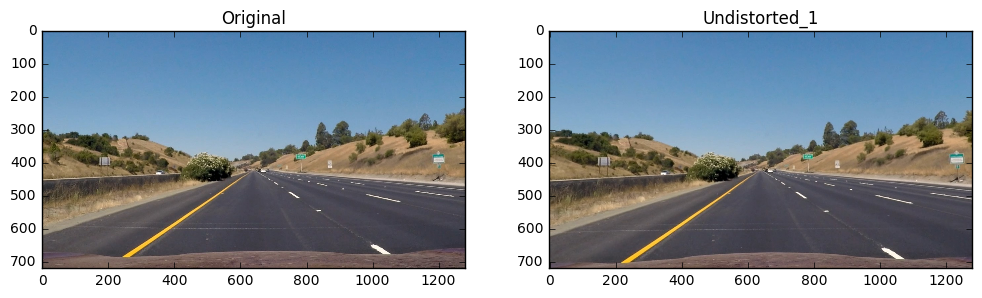

In [6]:
corrected1 = undistort_1(orig_img, camera_matrix, dist_coefs)
corrected2 = undistort_2(orig_img, camera_matrix, dist_coefs)


f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 18))
ax1.imshow(orig_img)
ax1.set_title('Original', fontsize=12)
ax2.imshow(corrected1)
ax2.set_title('Undistorted_1', fontsize=12)

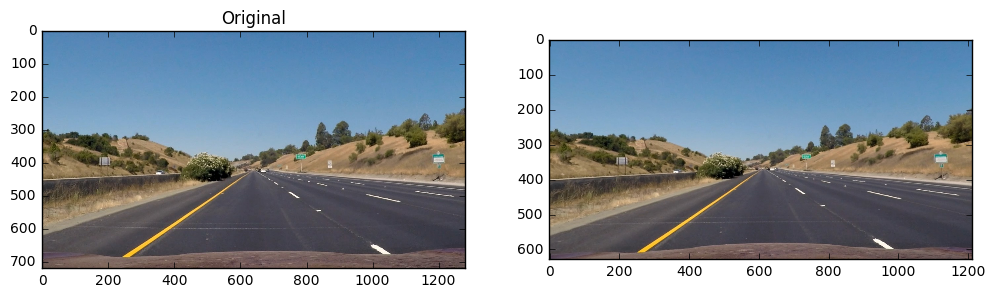

In [7]:
f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 18))
ax1.imshow(orig_img)
ax1.set_title('Original', fontsize=12)
ax2.imshow(corrected2)
ax3.set_title('Undistorted_2', fontsize=12)

In [8]:
def warper(image, src, dst):

    # Compute and apply perpective transform
    img_size = (image.shape[1], image.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped


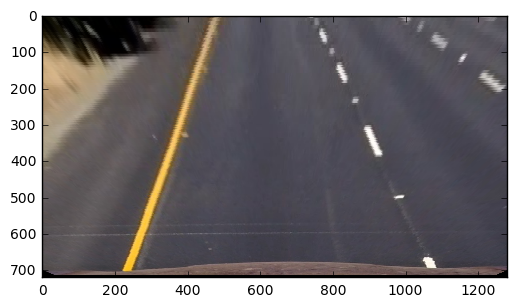

In [9]:
# Inverse Perspective Mappting
'''
Need more information
src = np.float32(
     [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
     [((img_size[0] / 6) - 10), img_size[1]],
     [(img_size[0] * 5 / 6) + 60, img_size[1]],
     [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])

dst = np.float32(
     [[(img_size[0] / 4), 0],
     [(img_size[0] / 4), img_size[1]],
     [(img_size[0] * 3 / 4), img_size[1]],
     [(img_size[0] * 3 / 4), 0]])
 '''
'''
src = np.float32([[500, 500],[250,675],[1000, 675],[775, 500]])

dst = np.float32(
     [[(img_size[0] / 4), 0],
     [(img_size[0] / 4), img_size[1]],
     [(img_size[0] * 3 / 4), img_size[1]],
     [(img_size[0] * 3 / 4), 0]])

## show points in the original image
# points = np.array([[500,500],[775,500],[1000,675],[250,675]])
# cv2.polylines(img, np.int32([points]), 1, (0,0,255))
# plt.imshow(img)
'''


src =  np.float32([[250,700],[1200,700],[550,450],[750,450]])
dst = np.float32([[250,700],[1200,700],[300,50],[1000,50]])
    
frm = warper(corrected1,src,dst)
plt.imshow(frm)



In [10]:
def illuminationHSV(image):
    rows,cols,channels = image.shape
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(image_hsv)
    cv2.normalize(h, h, alpha=0, beta=127, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(s, s, alpha=0, beta=127, norm_type=cv2.NORM_MINMAX)
    newImage = cv2.add(h,s)
    cv2.normalize(newImage, newImage, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    return newImage

In [11]:
def pre_process_canny(image):
    """
    Takes in an image and uses Canny Edge Detection 
    """
    # PARAMETERS
    imshape = image.shape
    kernel_size = 3
    sigma_x = 2
    sigma_y = 2
    low_canny_threshold = 25
    high_canny_threshold = low_canny_threshold * 3
    
    """
    # Adaptive Biateral Filter:

    image2 = cv2.adaptiveBilateralFilter(image,ksize=(5,5),sigmaSpace=2)

    # Equalize the histogram to account for better contrast in the images.

    image2 = cv2.equalizeHist(image2);

    # Apply Canny Edge Detector to detect the edges in the image.

    bin_img = cv2.Canny(image2,30,60,apertureSize = 3)
    
    """
    
    # GRAYSCALE
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    
    # Equalize the histogram to account for better contrast in the images.
    # hist = cv2.equalizeHist(gray);
    
    #gray = illuminationHSV(image)

    # GAUSSIAN BLUR
    blur = cv2.GaussianBlur(gray, (kernel_size, kernel_size), sigma_x, sigma_y)

    # CANNY EDGES
    canny_edges = cv2.Canny(blur, low_canny_threshold, high_canny_threshold)
    
    return canny_edges


In [12]:
#can_frm = pre_process_canny(undst)
#plt.imshow(can_frm,cmap='Greys_r')

In [13]:
def roi_mask(image):

    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    imshape = image.shape
    ''' 
    y_max = imshape[0]-70
    y_min = 11*imshape[0]/18
    x_min = 0
    x_1 = 9*imshape[1]/20
    x_2 = 11*imshape[1]/20
    x_max = imshape[1]
    '''
    y_max = imshape[0]-70
    y_min = imshape[0]/10
    x_min = 0 + 80
    x_1 = 5*imshape[1]/20
    x_2 = 15*imshape[1]/20
    x_max = imshape[1] - 80
    
    
    vertices = np.array([[(x_min,y_max), (x_1, y_min), (x_2, y_min),(x_max,y_max)]], dtype=np.int32)
    #defining a blank mask to start with
    mask = np.zeros_like(image)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(imshape) > 2:
        channel_count = imshape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, [vertices], ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

In [14]:
roi_frm = roi_mask(can_frm)
plt.imshow(roi_frm,cmap='Greys_r')
print(roi_frm.dtype, roi_frm.shape)

NameError: name 'can_frm' is not defined

In [25]:
# line detection

def line_detect(roi_frm, prob_hough= True):
    
    h,w = roi_frm.shape   # height and width in pixels

    rho = 1             # distance resolution in pixels of the Hough grid
    theta = 1*np.pi/180 # angular resolution in radians of the Hough grid
    hough_threshold = 30      # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20#minimum number of pixels making up a line
    max_line_gap = 5    # maximum gap in pixels between connectable line segments
    line_image = np.copy(orig_img)*0 # creating a blank to draw lines on

    print(line_image.shape)


    # Run Probabilistic Hough Transform to extract line segments from Binary image.
    lines = cv2.HoughLinesP(roi_frm,rho,theta,hough_threshold,min_line_length,max_line_gap)

    print('%d lines detect ...' % lines.shape[0],end='')

    y_max = h-70
    y_min = 11*h/18
    
    global PREV_LEFT_SLOPE, PREV_RIGHT_SLOPE, PREV_LEFT_POINTS, PREV_RIGHT_POINTS

    # DECLARE VARIABLES
    prev_weight = 0.9

    r_XY_arr = []
    r_Y_arr = []
    r_X_arr = []
    r_Slope_arr = []

    l_XY_arr = []
    l_Y_arr = []
    l_X_arr = []
    l_Slope_arr = []


    print(' processing ...',end='')
    # Loop for every single line detected by Hough Transform

    for line in lines:
        for x1,y1,x2,y2 in line:
            dx = x2 - x1
            dy = y2 - y1
            slope, yint = np.polyfit((x1, x2), (y1, y2), 1)
            theta = np.abs(np.arctan2((y2-y1), (x2-x1)))
            angle = theta * (180/np.pi)
            #angle = np.arctan2(np.array(y2-y1,dtype=np.float32),np.array(x2-x1,dtype=np.float32)) * (180/np.pi)

            
            
            if abs(angle)>20:         #for removing horizontal lines
                cv2.line(line_image,(x1,y1),(x2,y2),(0,255,0),2)
                # Right lane marking -> positive slope and in right half of the frame
                # Remove slope since this is not required now
                if x1 > 0.4*w and x2 > 0.4*w:
                    r_Y_arr.extend([y1,y2])
                    r_X_arr.extend([x1,x2])
                    #r_XY_arr = np.append(r_XY_arr,[[x1,x2],[y1,y2]],1)
                    r_Slope_arr.append(slope)
                    cv2.line(line_image,(x1,y1),(x2,y2),(0,255,0),2)
                # left lane marking -> negative slope and in left half of the frame
                # removed slope
                elif x1 < 0.6*w and x2 < 0.6*w:
                    l_Y_arr.extend([y1,y2])
                    l_X_arr.extend([x1,x2])
                    #l_XY_arr = np.append(l_XY_arr,[[x1,x2],[y1,y2]],1)
                    l_Slope_arr.append(slope)
                    cv2.line(line_image,(x1,y1),(x2,y2),(0,255,0),2)
    
    r_XY_arr = np.array((r_X_arr, r_Y_arr))
    l_XY_arr = np.array((l_X_arr, l_Y_arr))
    
    data_lanes = np.array((l_Slope_arr,r_Slope_arr,l_XY_arr,r_XY_arr))
                
    # DRAW RIGHT LANE LINE
    if r_Y_arr:
        r_ind = r_Y_arr.index(min(r_Y_arr))
        r_x1 = r_X_arr[r_ind]
        r_y1 = r_Y_arr[r_ind]
        r_slope = np.median(r_Slope_arr)
        
        #UPDATE SLOPE
        if PREV_RIGHT_SLOPE !=0:
            r_slope = r_slope + (PREV_RIGHT_SLOPE - r_slope) * prev_weight

        r_x2 = int(r_x1 + (y_max - r_y1) / r_slope)

        # UPDATE REST OF THE COORDINATES
        if PREV_RIGHT_SLOPE !=0:
            r_x1 = int(r_x1 + (PREV_RIGHT_POINTS[0] - r_x1) * prev_weight)
            r_y1 = int(r_y1 + (PREV_RIGHT_POINTS[1] - r_y1) * prev_weight)
            r_x2 = int(r_x2 + (PREV_RIGHT_POINTS[2] - r_x2) * prev_weight)

        PREV_RIGHT_SLOPE = r_slope
        PREV_RIGHT_POINTS = [r_x1, r_y1, r_x2]
        print('Right',r_x1, r_y1, r_x2, y_max)
        cv2.line(line_image, (r_x1, r_y1), (r_x2, y_max), (255,255,255), 5)
        

    # DRAW LEFT LANE LINE
    if l_Y_arr:
        #l_ind = l_Y_arr.index(min(l_Y_arr))
        l_ind = l_X_arr.index(max(l_X_arr))
        l_x1 = l_X_arr[l_ind]
        l_y1 = l_Y_arr[l_ind]
        l_slope = np.median(l_Slope_arr)
        print(l_slope)
        print(l_x1,l_y1)
        if PREV_LEFT_SLOPE !=0:
            print('ok1')
            l_slope = l_slope + (PREV_LEFT_SLOPE - l_slope) * prev_weight

        l_x2 = int(l_x1 + (y_max - l_y1) / l_slope)
        print(l_x2)

        if PREV_LEFT_SLOPE !=0:
            print('ok2')
            l_x1 = int(l_x1 + (PREV_LEFT_POINTS[0] - l_x1) * prev_weight)
            l_y1 = int(l_y1 + (PREV_LEFT_POINTS[1] - l_y1) * prev_weight)
            l_x2 = int(l_x2 + (PREV_LEFT_POINTS[2] - l_x2) * prev_weight)

        PREV_LEFT_SLOPE = l_slope
        PREV_LEFT_POINTS = [l_x1, l_y1, l_x2]
        print('Left' ,l_x1, l_y1, l_x2, y_max)
        cv2.line(line_image, (l_x1, l_y1), (l_x2, y_max), (255,255,0), 5)
    
    return(line_image,data_lanes)

SyntaxError: invalid syntax (<ipython-input-25-2256885e611e>, line 58)

In [ ]:

# Create a "color" binary image to combine with line image
#color_edges = np.dstack((line_image, line_image, line_image)) 
line_image, data_lanes = line_detect(roi_frm, prob_hough= True)

# Draw the lines on the edge image
combo = cv2.addWeighted(line_image, 0.8, undst, 1, 0) 
plt.imshow(combo)

In [ ]:
## SELECTING POINTS BASED ON SLOPES
def process_slopes(data_lanes):
    print(len(data_lanes[0]))
    l_slope_sdev = np.std(data_lanes[0])
    l_slope_median = np.median(data_lanes[0])
    l_slope_avg = np.average(data_lanes[0])
    l_slope_min = np.min(data_lanes[0])
    l_slope_max = np.max(data_lanes[0])
    l_angle_min = np.arctan(np.abs(l_slope_min)) * 180/(np.pi)
    l_angle_max = np.arctan(np.abs(l_slope_max)) * 180/(np.pi)
    print(l_slope_median,l_slope_avg,l_slope_sdev,l_slope_min,l_slope_max,l_angle_min,l_angle_max)

    l_slope_upper = l_slope_avg + l_slope_sdev
    l_slope_lower = l_slope_avg - l_slope_sdev
    l_angle_lower = np.arctan(np.abs(l_slope_lower)) * 180/(np.pi)
    l_angle_upper = np.arctan(np.abs(l_slope_upper)) * 180/(np.pi)
    print(l_slope_lower,l_slope_upper,l_angle_lower,l_angle_upper)

    cnt = 0;
    l_ind = []
    for sl in data_lanes[0]:
        if sl > l_slope_lower and sl<=l_slope_upper:
            l_ind = np.append(l_ind,cnt)
        cnt = cnt + 1
    print(len(l_ind))
    print(int(l_ind))
    #l_XYs = data_lanes[:,int(l_ind)]

    print(len(data_lanes[1]))
    r_slope_sdev = np.std(data_lanes[1])
    r_slope_median = np.median(data_lanes[1])
    r_slope_avg = np.average(data_lanes[1])
    r_slope_min = np.min(data_lanes[1])
    r_slope_max = np.max(data_lanes[1])
    r_angle_min = np.arctan(np.abs(r_slope_min)) * 180/(np.pi)
    r_angle_max = np.arctan(np.abs(r_slope_max)) * 180/(np.pi)
    print(r_slope_median,r_slope_avg,r_slope_sdev,r_slope_min,r_slope_max,r_angle_min,r_angle_max)
    
    return(l_slope_lower,l_slope_upper)

In [ ]:
def ransac(image, edges, points):
    ''' Performs the RANSAC algorithm upon an input
        image and its corresponding pre-processed
        image, outputting an image with lines drawn
        on it and printing the amount of lines to stdout '''
    
    # Initialise variables
    rows,cols,channels = image.shape
    white = np.nonzero(edges)
    length = len(white[0])
    
    densestLine = -1
    bestInliers = 0
    lineCounter = 0
    iterations = 10000
    
    # While we have strong lines (probably road edges), enough edges and not
    # more than 4 lines (roads in UK don't have more 4)
    while bestInliers > (densestLine / 2) and lineCounter < 5 and length > 1000:
        # Build a bank of the locations of edge pixels
        white = np.nonzero(edges)
        length = len(white[0])
        
        # Initialise variables
        bestInliers = 0
        bestLine = []
        
        # Find lines, updating best if beaten
        for i in range (iterations + 1):
            # Select two random points
            rand1 = random.randrange(length)
            rand2 = random.randrange(length)
            x1,y1 = white[1][rand1],white[0][rand1]
            x2,y2 = white[1][rand2],white[0][rand2]
            # Heuristic to eliminate vertical and horizontal lines
            # keep selecting points until heuristics aren't violated
            cycles = 0
            while abs(x1 - x2) < 50 or abs(y1 - y2) < 50 or abs(x1 - x2) > 200:
                rand1 = random.randrange(length)
                rand2 = random.randrange(length)
                x1,y1 = white[1][rand1],white[0][rand1]
                x2,y2 = white[1][rand2],white[0][rand2]
                cycles += 1
                if cycles > 100000:
                    break
            # Create blank image
            lineImage = np.zeros((rows,cols), np.uint8)
            # Draw line between two points on blank image
            cv2.line(lineImage, (x1,y1), (x2,y2), (255,255,255), 1)
            # Logically AND the line image and processed image
            intersect = cv2.bitwise_and(edges, lineImage)
            # Calculate the number of inliers to the line
            inliers = cv2.countNonZero(intersect)
            # Modify best if necessary
            if inliers >= bestInliers:
                bestInliers = inliers
                bestLine = [(x1,y1), (x2,y2)]
            if cycles > 100000:
                break
        # Update global best to help know when to stop
        if bestInliers > densestLine:
            densestLine = bestInliers
        # Only draw line if it's a strong line (potential road edge)
        if bestInliers > (densestLine / 2):
            # Draw the line on the image
            cv2.line(image, bestLine[0], bestLine[1], (0,0,255), 1)
            # Prevent choosing this same line again my removing edges
            cv2.line(edges, bestLine[0], bestLine[1], (0,0,0), 75)
            lineCounter += 1
        if cycles > 100000:
            break
    return [image, lineCounter]

In [18]:
# PARAMETERS

camera_matrix, dist_coefs = camera_cal('camera_cal','calibration',10,7,1)

(720, 1280, 3)
160 lines detect ... processing ...Right 1075 226 2413 650
0.958069620253
324 644
ok1
330
ok2
Left 324 644 330 650


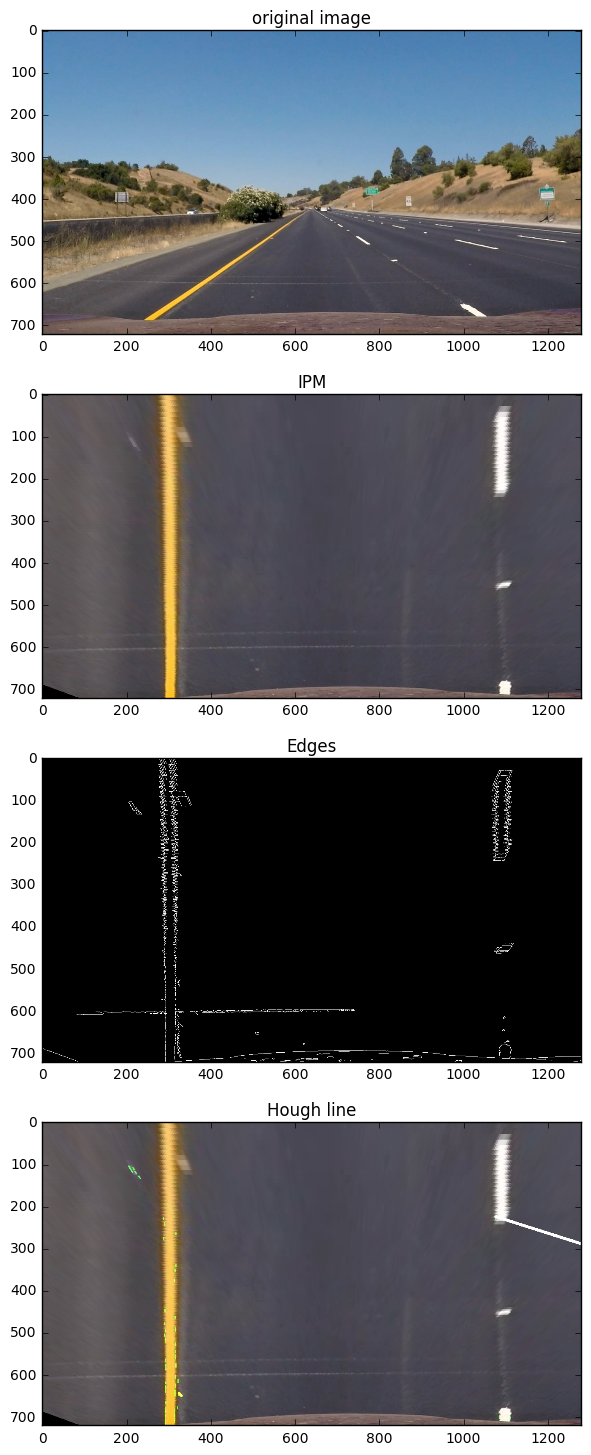

In [26]:
# PIPELINE

orig_img = mpimg.imread(path)
img_size = orig_img.shape

corrected_img = undistort_1(orig_img, camera_matrix, dist_coefs)

src =  np.float32([[260,680],[1045,680],[540,490],[750,490]])
dst = np.float32([[300,700],[1100,700],[300,50],[1100,50]])
    
top_view = warper(corrected_img,src,dst)
canny_edges = pre_process_canny(top_view)
#roi_frm = roi_mask(canny_edges)

line_image, data_lanes = line_detect(canny_edges,True)

# Draw the lines on the edge image
combo = cv2.addWeighted(line_image, 0.8, top_view, 1, 0) 

# plt.imshow(roi_frm,cmap='Greys_r')

f, ((ax1, ax2, ax3, ax4)) = plt.subplots(4, 1, figsize=(12, 18))
ax1.imshow(orig_img)
ax1.set_title('original image', fontsize = 12)
ax2.imshow(top_view)
ax2.set_title('IPM', fontsize=12)
ax3.imshow(canny_edges, cmap = 'Greys_r')
ax3.set_title('Edges', fontsize=12)
ax4.imshow(combo)
ax4.set_title('Hough line', fontsize=12)
ax4.imshow(combo)
ax4.set_title('Hough line', fontsize=12)



In [22]:
print(data_lanes[0])

[1.0856164383561644, 0.95806962025316478, 1.1289808917197452, 0.77147766323024047, 0.88370253164556956, 0.78085443037974689, 0.87413793103448267, 0.99317406143344689, 1.1994863013698629, 1.0571672354948807, 0.401567944250871, 0.82672413793103461, 0.97003424657534232, 0.42034700315457413, 0.73809523809523825, 0.99208860759493689, 0.95496894409937871, 0.91167192429022059, 1.1106687898089174, 1.0939490445859874, 0.84845890410958891, 0.41896551724137937, 1.0568535825545173, 0.56111111111111112, 0.86313291139240511, 0.83544303797468344, 1.0214285714285716, 0.60031847133757954, 1.1373720136518768, 0.88784246575342463, 0.99922839506172823, 1.1703767123287669, 0.53864353312302837, 1.2217465753424657, 1.6666666666666752, 1.4999999999999964, 0.48177083333333326, 1.6666666666666632, 1.6666666666666319]


In [23]:
print(data_lanes[1])

[0.10651162790697673, 0.32310885608856088, 0.31672678088367895]


In [24]:
print(data_lanes[2])

[[292 292 316 316 314 314 291 291 316 316 316 316 290 290 293 293 292 292
  293 293 287 287 290 290 292 292 317 317 315 315 316 316 322 322 317 317
  314 314 314 314 292 292 290 290 321 321 315 315 316 316 316 316 315 315
  314 314 293 293 292 292 324 324 292 292 317 317 292 292 215 218 229 233
  288 288 205 214 220 223]
 [626 642 609 602 713 705 452 446 563 554 489 498 510 504 575 589 695 706
  617 622 233 228 477 482 564 569 269 264 468 462 631 623 611 619 583 573
  701 694 692 682 498 493 246 240 676 681 356 351 543 548 531 525 650 637
  374 380 664 669 514 523 644 651 677 690 339 344 708 719 110 115 130 136
  280 275 106 121 119 124]]
